In this notebook, I plan to plot basic dark photon kinematic variables to understand dark photon kinematics and to validate the signal samples and analysis code

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea.nanoevents import NanoAODSchema
from coffea import processor
# local
sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [2]:
samples = [
    '2Mu2E_500GeV_5p0GeV_80p0mm',
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2_merged", max_files=1, location_cfg="signal_v6.yaml")
fileset

/home/cms-jovyan/SIDM/sidm


{'2Mu2E_500GeV_5p0GeV_80p0mm': ['root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-80p0.root']}

In [3]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    maxchunks=1,
    skipbadfiles=True
)

channels = [
    "baseNoLj",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["genA_base", "genA_toMu_base", "genA_toE_base"],
    #verbose=True,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]
hists = out[samples[0]]["hists"]
ch = channels[0]

Output()

Output()

Not applying any obj cuts after LJ clustering for channel baseNoLj

Not applying any obj cuts after lj clustering for channel  baseNoLj

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered 
in divide
  result = getattr(ufunc, method)(

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in
divide
  result = getattr(ufunc, method)(

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [4]:
def plot_row(plots):
    n = len(plots)
    plt.subplots(1, n, figsize=(12*n, 10))
    for i, plot in enumerate(plots):
        plt.subplot(1, n, i+1)
        utilities.plot(hists[plot][ch, :])

def plot_row_2d(plots):
    n = len(plots)
    plt.subplots(1, n, figsize=(12*n, 10))
    for i, plot in enumerate(plots):
        plt.subplot(1, n, i+1)
        utilities.plot(hists[plot][ch, :, :])

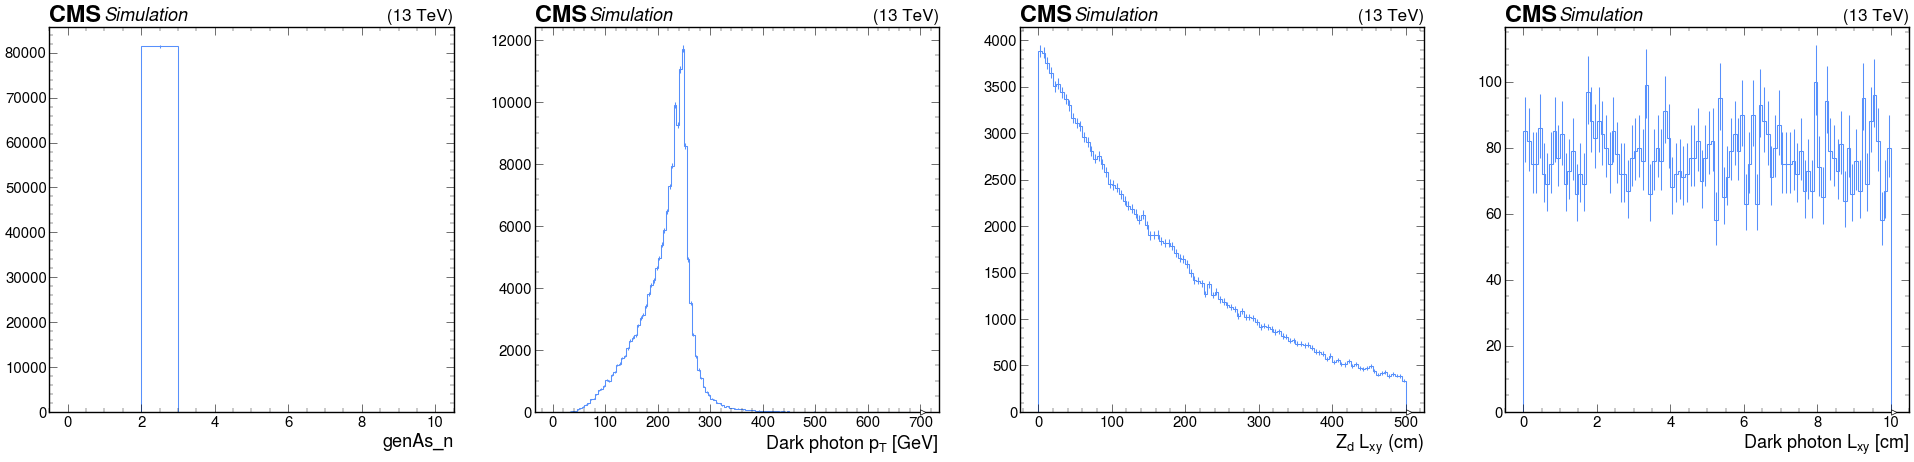

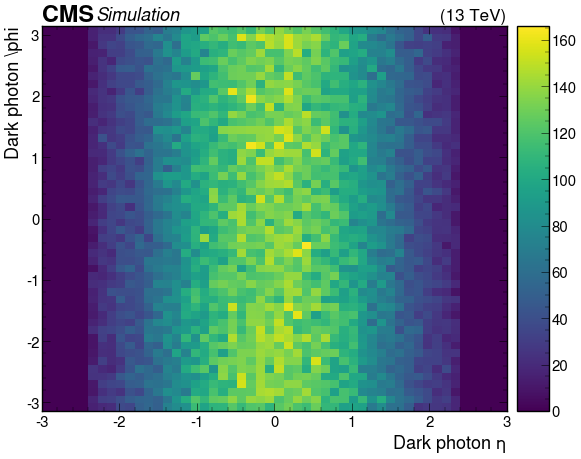

In [5]:
plots = [
    "genAs_n",
    "genAs_pt_highRange",
    "genAs_lxy",
    "genAs_lxy_lowRange",
]
plot_row(plots)
plot_row_2d(["genAs_eta_phi"])

The number of dark photons and their pT, eta, phi, and Lxy look good. Now look into info on their children and production vertex.

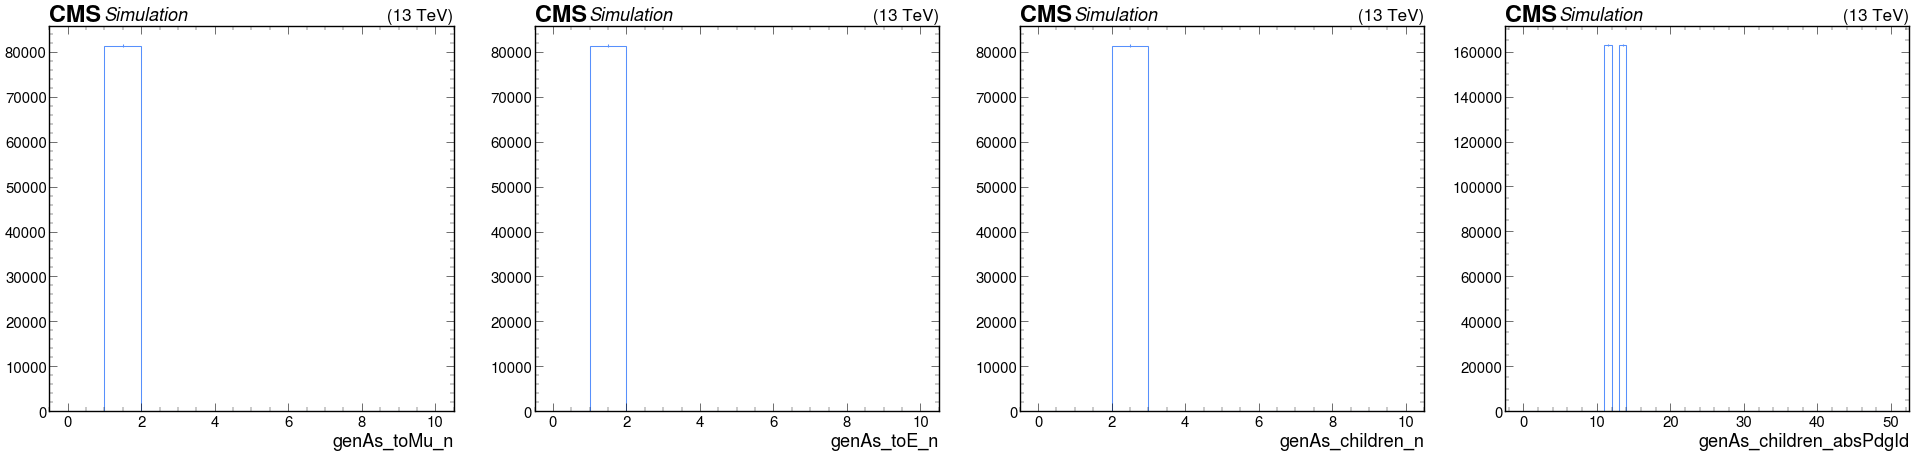

In [6]:
plots = [
    "genAs_toMu_n",
    "genAs_toE_n",
    "genAs_children_n",
    "genAs_children_absPdgId",
]
plot_row(plots)

All looks good. Now let's look at the vertices

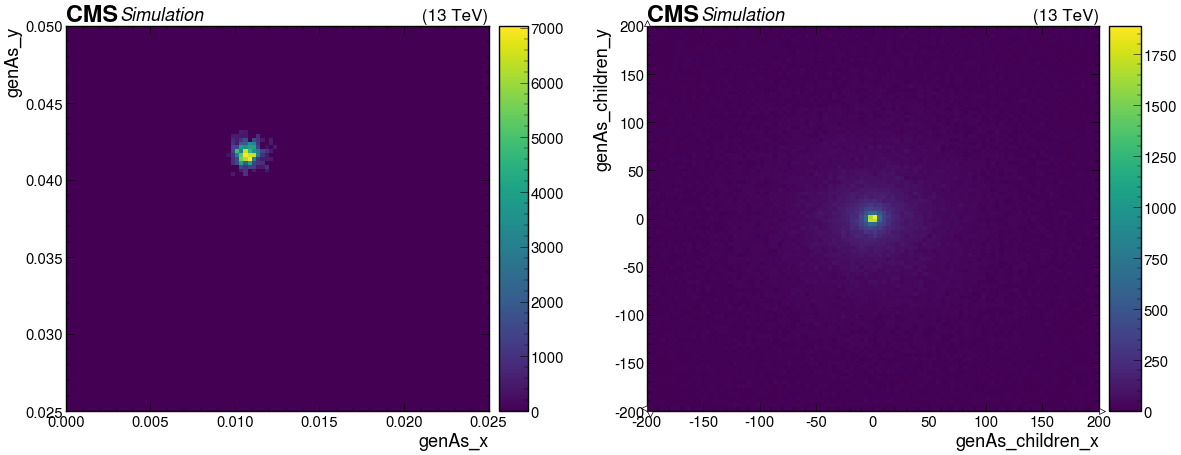

In [7]:
plots = [
    "genAs_x_y",
    "genAs_children_x_y",
]
plot_row_2d(plots)